In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
import torch
import pandas as pd
import matplotlib.pyplot as plt
from statistics import stdev, mean
import numpy as np
from scipy.stats import spearmanr
from src.utils.analysis_utils import extract_scatter, get_traintest, hastok, aggregate_clusters

from src.utils.samp_utils import inpsampall, dset_randsamp   
from src.tfr_decoding.shp_modeling import T5BinaryClassifier, validate
from prefix_sampling import PrefixSampler, test_baseline, test_pfsample, test_finesample, test_apsample
import pytorch_lightning as pl

2023-05-24 08:47:22.962393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 08:47:22.962418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
EBASE = "output/"
df = pd.read_json(EBASE+"testsetlarge.jsonl", orient="records", lines=True)

In [4]:
df

,inp,hyp,pflen,sco,label
0,Why was Gollum not able to harvest the powers ...,There are a,3,0.848287,205
1,Why was Gollum not able to harvest the powers ...,"Gollum possesses the Ring of Power, but he",8,0.841349,205
2,Why was Gollum not able to harvest the powers ...,Sauron was able to harness all the powers of t...,12,0.721043,272
3,Why was Gollum not able to harvest the powers ...,There are a couple theories as to why Gollum i...,22,0.848287,205
4,Why was Gollum not able to harvest the powers ...,"Gollum possesses the Ring of Power, but he can...",10,0.841349,205
...,...,...,...,...,...
33121,The commercial use of an internet meme which c...,"I think memes are protected as IP, just like s...",12,0.798433,205
33122,The commercial use of an internet meme which c...,There are a few reasons why this is not allowe...,22,0.899125,309
33123,The commercial use of an internet meme which c...,Most memes are copyrighted. If you are trying ...,10,0.833054,205
33124,The commercial use of an internet meme which c...,I think memes are protected,5,0.798433,205


In [19]:
with torch.no_grad():
    res = validate(df[:1000], "lightning_logs/multimodel/checkpoints/epoch=3-step=86946.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at lightning_logs/multimodel/checkpoints/epoch=3-step=86946.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at lightning_logs/multimodel/checkpoints/epoch=3-step=86946.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │           0.53            │
└───────────────────────────┴───────────────────────────┘

In [21]:
from sklearn.metrics import confusion_matrix


In [27]:
preds = [CLASSES.index(r) for r in res[1]]
labs = [CLASSES.index(r) for r in res[0]]

In [28]:
cm = confusion_matrix(preds, labs)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [29]:
cm_percent

array([[0.52513966, 0.23463687, 0.20670391, 0.03351955],
       [0.18439716, 0.32624113, 0.41134752, 0.07801418],
       [0.10280374, 0.13084112, 0.48286604, 0.2834891 ],
       [0.03064067, 0.03342618, 0.28133705, 0.6545961 ]])

In [11]:
CLASSES = [71, 272, 205, 309]
df['lab'] = [CLASSES.index(l) for l in df.label]

In [18]:
df[df.lab==3]

,inp,hyp,pflen,sco,label,lab
6,Moral turpitudeHow would you explain it? Just ...,Moral turpitude is a legal term that refers to...,25,0.876595,309,3
7,Moral turpitudeHow would you explain it? Just ...,"Moral turpitude, in legal parlance, means ""the...",10,0.862430,309,3
8,Moral turpitudeHow would you explain it? Just ...,Moral turpitude is a legal term for acts that ...,12,0.857247,309,3
9,Moral turpitudeHow would you explain it? Just ...,Moral turpitude is a legal term that refers to...,21,0.876595,309,3
10,Moral turpitudeHow would you explain it? Just ...,"Moral turpitude, in legal parlance, means ""the",7,0.862430,309,3
...,...,...,...,...,...,...
33113,TerrariumsHow to sealed terrariums maintain life?,"Terrariums can be maintained with plants, rock...",9,0.914250,309,3
33116,Can someone please explain why they always ins...,"For example, if a group of people were walking...",17,0.908945,309,3
33119,Can someone please explain why they always ins...,"For example, if a group of people were walking...",20,0.908945,309,3
33122,The commercial use of an internet meme which c...,There are a few reasons why this is not allowe...,22,0.899125,309,3


In [13]:
cm_percent

array([[0.62486249, 0.06930693, 0.2640264 , 0.04180418],
       [0.26287979, 0.08718626, 0.54689564, 0.10303831],
       [0.09777478, 0.04922454, 0.55023601, 0.30276467],
       [0.03241491, 0.01080497, 0.29875743, 0.65802269]])

(array([ 6167.,     0.,     0.,  5647.,     0.,     0.,  9576.,     0.,
            0., 11736.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

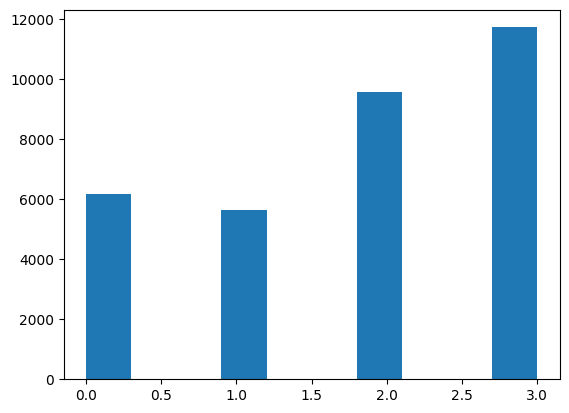

In [14]:
plt.hist(df.label)

In [ ]:
res[1]

In [6]:
smaller = df.iloc[:5000]

In [11]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")

In [26]:
tokenizer("D")

{'input_ids': [309, 1], 'attention_mask': [1, 1]}

In [ ]:
# A, B, C, D are the classes
[71, 272, 205, 309]

In [165]:
del qpref

In [3]:
pfmod_path = "lightning_logs/version_13/checkpoints/epoch=1-step=31466.ckpt"
pfname = 'stanfordnlp/SteamSHP-flan-t5-large'
# get prefix model
qpref = T5BinaryClassifier.load_from_checkpoint(pfmod_path)
preftok = T5Tokenizer.from_pretrained(pfname)

In [8]:
inp = qpref.getinp(df.loc[0]['inp'], df.loc[0]['hyp'])

In [17]:
df.loc[0]

inp      Why was Gollum not able to harvest the powers ...
hyp                                            There are a
pflen                                                    3
sco                                               0.848287
label                                                  205
Name: 0, dtype: object

In [42]:
torch.cuda.empty_cache()

In [46]:
with torch.no_grad():
    print(qpref(inp['input_ids'], inp["attention_mask"], torch.tensor(1000).unsqueeze(-1).to(qpref.device)).loss)

tensor(19.2436, device='cuda:0')


In [ ]:
inp

In [6]:
trainer = pl.Trainer(
    max_epochs=3,
    # gpus=torch.cuda.device_count(),
    log_every_n_steps=1,
    #check_val_every_n_epoch=val_interval,
    val_check_interval=500,
    #callbacks=[checkpoint_callback],
    enable_checkpointing=True,
    #early_stop_callback=None
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.validate(qpref, df)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_2484254/3659586131.py:1 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2484254/3659586131.py'               │
│ /home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/pytorch_lightning/tra │
│ iner/trainer.py:609 in validate                                                           │
│                                                                                           │
│    606 │   │   else:                                                                      │
│    607 │   │   │   model = _maybe_unwrap_optimized(model)                                 │
│    608 │   │   │   self.strategy._lightning_module = model                                │
│ ❱  609 │   │   return call._call_and_handle_interrupt(                                    │
│    610 │   │   │   self, self._validate_impl, model, dataloaders, ckpt_path, verbose, dat │
│    611 │   │   )                                                                          │
│    612                                                                                    │
│                                                                                           │
│ /home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/pytorch_lightning/tra │
│ iner/call.py:42 in _call_and_handle_interrupt                                             │
│                                                                                           │
│    39 │   """                                                                             │
│    40 │   try:                                                                            │
│    41 │   │   if trainer.strategy.launcher is not None:                                   │
│ ❱  42 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trai │
│    43 │   │   else:                                                                       │
│    44 │   │   │   return trainer_fn(*args, **kwargs)                                      │
│    45                                                                                     │
│                                                                                           │
│ /home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/pytorch_lightning/str │
│ ategies/launchers/multiprocessing.py:99 in launch                                         │
│                                                                                           │
│    96 │   │   """                                                                         │
│    97 │   │   self._check_torchdistx_support()                                            │
│    98 │   │   if self._start_method in ("fork", "forkserver"):                            │
│ ❱  99 │   │   │   _check_bad_cuda_fork()                                                  │
│   100 │   │                                                                               │
│   101 │   │   # The default cluster environment in Lightning chooses a random free port n │
│   102 │   │   # This needs to be done in the main process here before starting processes  │
│                                                                                           │
│ /home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/lightning_fabric/stra │
│ tegies/launchers/multiprocessing.py:189 in _check_bad_cuda_fork                           │
│                                                                                           │
│   186 │   )                                                                               │
│   187 │   if _IS_INTERACTIVE:                     

In [ ]:
validate(df, pfmod_path)

In [8]:
df = df.fillna("")

In [9]:
# define the function to tokenize and then decode
def tokenize_and_decode(row):
    if type(row['prefix']) is float:
        
        # tokenization
        tokens = tokenizer.tokenize(row['hyps'][0])
        # select the first 'pref' tokens
        selected_tokens = tokens[:int(row['prefix'])]
        # decoding
        text = tokenizer.convert_tokens_to_string(selected_tokens)
        
        return text
    else:
        return row['hyps'][0]

# create the new column
df['prefstr'] = df.apply(tokenize_and_decode, axis=1)

In [10]:
preds = []
prob = []
for ind in range(4090):
    print(df['prefstr'].iloc[ind])
    out = qpref.predsingle(df['inp'].iloc[ind], df['prefstr'].iloc[ind], True)
    transition_scores = qpref.model.compute_transition_scores(
        out.sequences, out.scores, normalize_logits=True
    )
    prob.append(float(np.exp(transition_scores[0][-1].cpu())))
    preds.append(float(np.argmax(out.scores[-1].cpu())))
    print(prob[-1], " ", preds[-1])
    del out
    del transition_scores

Your body burns 2000 calories a day just for the very basic needs of survival and metabolism. If you are a man and you eat 2000 calories a day, your body burns 2000 calories a day just from breathing and digestion. If you are a woman, your body burns 2000 calories a day just from generating heat for the body. The difference is that a man burns the extra calories that are required to perform aerobic exercise. An aerobic exercise is any activity in which a person breathes faster and/or harder. It is a high intensity activity in which a person breathes faster and/or harder and is more strenuous. The average person burns around 2000 calories a day by just breathing and digesting. A man who burns an extra 2000 calories a day by exercising will burn roughly 2600 calories a day. A man who burns an extra 2600 calories a day by exercising will burn another 1500 calories in total. The average person burns an extra 1000 calories a day by exercising. The difference between the two is that a man wi

/home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/transformers/generation/utils.py:1029: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:671.)
  beam_indices[beam_indices_mask] = 0
/home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/transformers/generation/utils.py:1029: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1223.)
  beam_indices[beam_indices_mask] = 0


0.8725225925445557   0.0
Your body burn
0.9911336898803711   0.0
Your body burns calories to
0.9961518049240112   0.0
Your body burns calories to perform basic functions
0.9979593753814697   0.0
Your body burns calories to perform basic functions, such as
0.9981570243835449   0.0
Your body burns calories to perform basic functions, such as breathing, digestion
0.9981276392936707   0.0
Your body burns calories to perform basic functions, such as breathing, digestion, and heart
0.9982239007949829   0.0
Your body burns calories to perform basic functions, such as breathing, digestion, and keeping warm.
0.9985182285308838   0.0
Your body burns calories to perform basic functions, such as breathing, digestion, and keeping warm. This energy is called
0.9987089037895203   0.0
Your body burns calories to perform basic functions, such as breathing, digestion, and keeping warm. This energy is necessary to keep you
0.9988610148429871   0.0
Your body burns calories to perform basic functions, such

In [11]:
df['probs']=prob

In [12]:
df['preds']=preds

In [13]:
df = df.drop(columns=["stats"])

In [19]:
resamps = df[df.ver=="rand"].reset_index()

In [18]:
df['max'] = df['scos'].apply(max)
df['mean'] = df['scos'].apply(lambda x: sum(x)/len(x))

In [25]:
groups = [g for _, g in resamps.groupby('inp')]

In [ ]:
heurcount=0
tot=0
for g in groups:
    if max(g['adjprob']>0.05):
        if max(g['mean'])>0.8:
            heurcount= heurcount+1
    else:
        if max(g['mean'])<0.8: 
            heurcount= heurcount+1
    tot = tot+1
heurcount/tot

In [42]:
tot

198

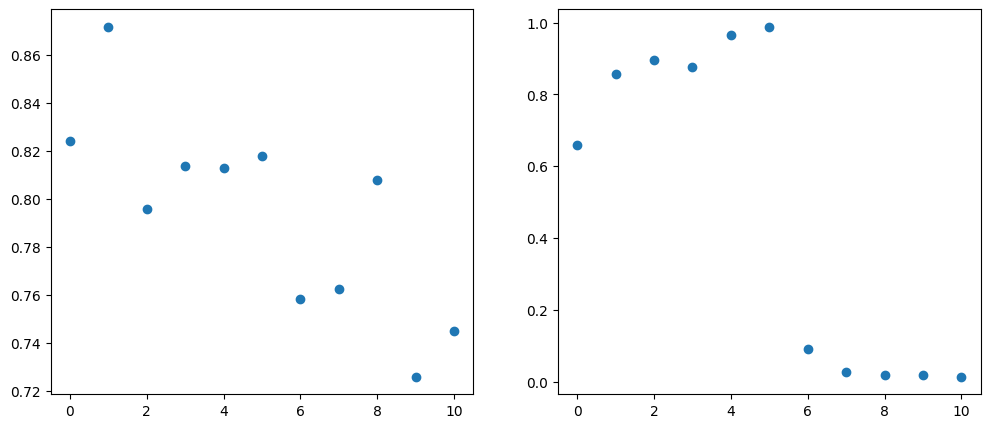

In [26]:
gind = 28
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(range(len(groups[gind])), list(groups[gind]['mean']))
ax[1].scatter(range(len(groups[gind])), list(groups[gind]['adjprob']))

In [ ]:
ax[0].scatter(subset['prefpercent'].iloc[:cutoff], subset['improves'].iloc[:cutoff]+subset['initsco'].iloc[0])

In [24]:
resamps['adjprob'] = adjprobs

In [22]:
adjprobs = []
for i in range(len(resamps)):
    if resamps['preds'].loc[i]==0:
        adjprobs.append(1-resamps['probs'].loc[i])
    else:
        adjprobs.append(resamps['probs'].loc[i])

(array([2730.,  117.,   57.,   38.,   29.,   58.,   42.,   47.,   84.,
         690.]),
 array([2.87175179e-04, 1.00252074e-01, 2.00216973e-01, 3.00181872e-01,
        4.00146770e-01, 5.00111669e-01, 6.00076568e-01, 7.00041467e-01,
        8.00006366e-01, 8.99971265e-01, 9.99936163e-01]),
 <BarContainer object of 10 artists>)

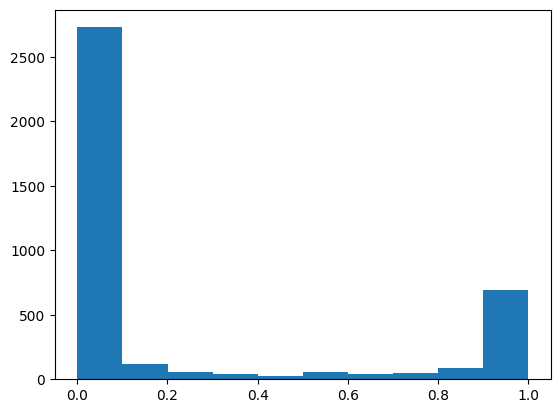

In [23]:
plt.hist(adjprobs)

In [108]:
spearmanr(adjprobs, list(resamps['mean']))

SpearmanrResult(correlation=0.7099587632892959, pvalue=0.0)

(array([ 18.,  46., 118., 195., 404., 603., 677., 784., 675., 372.]),
 array([0.2248256 , 0.30013165, 0.37543771, 0.45074377, 0.52604982,
        0.60135588, 0.67666193, 0.75196799, 0.82727404, 0.9025801 ,
        0.97788616]),
 <BarContainer object of 10 artists>)

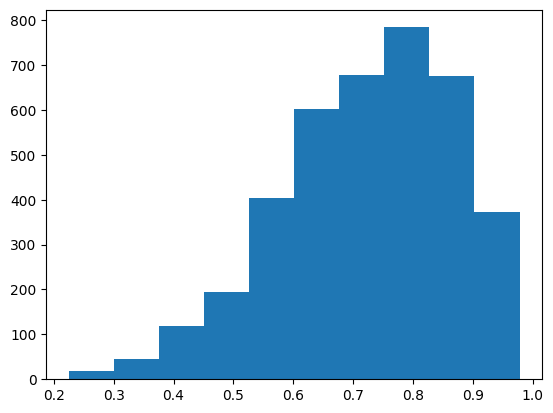

In [111]:
plt.hist(list(resamps['mean']))

In [159]:
def getres(fname):
    res = pd.read_json(fname, orient="records", lines=True)
    print(res['budgets'].mean())
    print(res['scos'].mean())

In [164]:
getres("output/hparam_explore/fsamp18_3_3_5.jsonl")
getres("output/hparam_explore/fsamp9_3_6_5.jsonl")
getres("output/hparam_explore/pfsamp_10_20.jsonl")
getres("output/hparam_explore/pfsamp_5_20.jsonl")

121.81
0.7706284520080002
109.61
0.7560847067820002
133.28
0.847768219114
116.14
0.829074999393


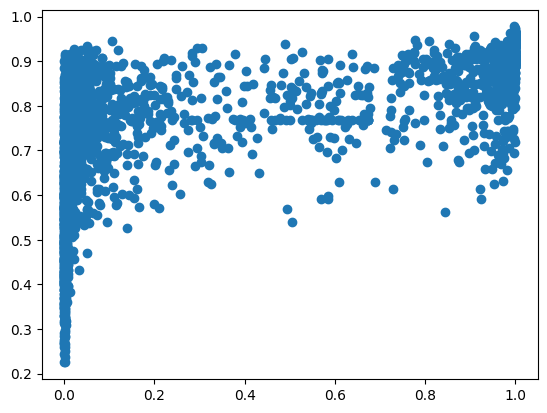

In [109]:
plt.scatter(adjprobs, list(resamps['max']))

In [95]:
ind = 6
out = qpref.predsingle(df['inp'].iloc[ind], df['prefstr'].iloc[ind], True)

In [60]:
torch.argmax(out.scores[1])

tensor(0, device='cuda:1')

In [72]:
out.scores


(tensor([[22.5365, 16.1361,  0.6723,  ...,  7.9948,  8.0494,  8.0365]],
        device='cuda:1'),
 tensor([[22.5365, 16.1361,  0.6723,  ...,  7.9948,  8.0494,  8.0365]],
        device='cuda:1'))

In [3]:
# check values of hparam explore

In [3]:
def checkvals(instr):
    tmp = pd.read_json(instr, orient='records', lines=True)
    print(tmp['scos'].mean())
    print(tmp['budgets'].mean())
    return tmp

nsamp = checkvals("output/hparam_explore2/pfsamp_5_20.jsonl")

0.8376028481601667
125.11


(array([  2.,   7.,   2.,   5.,  25.,  36.,  43., 106., 211., 163.]),
 array([0.26569238, 0.33782907, 0.40996575, 0.48210244, 0.55423912,
        0.62637581, 0.69851249, 0.77064918, 0.84278587, 0.91492255,
        0.98705924]),
 <BarContainer object of 10 artists>)

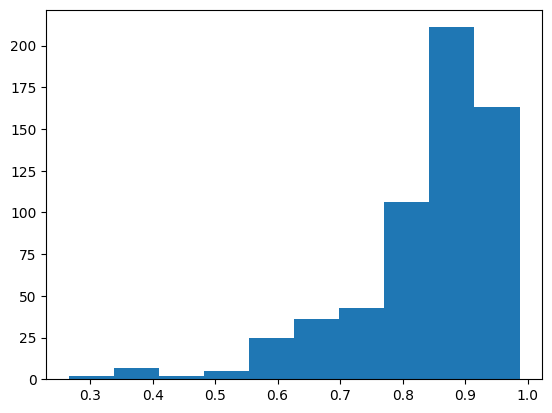

In [4]:
plt.hist(nsamp.scos)

In [5]:
base4 = checkvals("output/hparam_explore2/base4.jsonl")

0.8569375929250002
173.125


(array([  4.,   7.,  11.,  15.,  48.,  76., 142., 169.,  83.,  45.]),
 array([0.56422812, 0.60741124, 0.65059435, 0.69377747, 0.73696059,
        0.78014371, 0.82332683, 0.86650994, 0.90969306, 0.95287618,
        0.9960593 ]),
 <BarContainer object of 10 artists>)

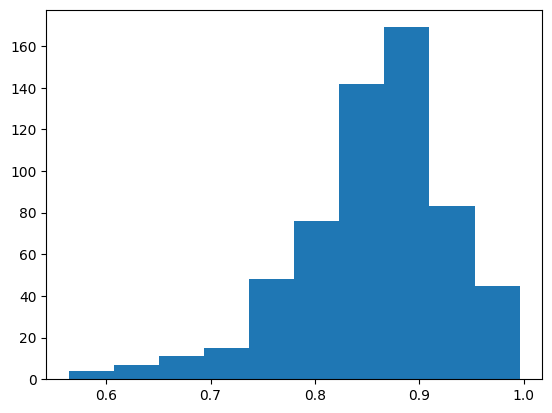

In [6]:
plt.hist(base4.scos)

In [9]:
def count_tokens(text):
    return len(tokenizer(text).input_ids)

base4['extra_toks'] = base4['budgets'] - base4['outs'].apply(count_tokens)

In [12]:
nsamp['extra_toks'] = nsamp['budgets'] - nsamp['outs'].apply(count_tokens)

In [14]:
base4['extra_toks'].mean()

91.06666666666666

In [28]:
from statistics import mean
import random

In [32]:
def paired_boottest(nsamps, scores_a, scores_b):
    inds = list(range(len(scores_a)))
    resdist = []
    for i in range(nsamps):
        isamp = random.choices(inds, k=len(inds))
        if i==1:
            print(isamp)
        avals = [scores_a[ind] for ind in isamp]
        bvals = [scores_b[ind] for ind in isamp]
        if mean(avals)>mean(bvals):
            resdist.append(0)
        else:
            resdist.append(1)
    return mean(resdist)

In [38]:
paired_boottest(10000, base4['scos'], nsamp['scos'])

[133, 76, 389, 447, 187, 233, 358, 153, 579, 297, 197, 576, 459, 584, 567, 242, 206, 505, 278, 283, 223, 299, 167, 193, 153, 9, 53, 220, 337, 96, 594, 87, 339, 435, 478, 313, 47, 265, 507, 301, 152, 172, 3, 419, 203, 4, 287, 46, 141, 10, 301, 146, 361, 31, 209, 199, 414, 95, 170, 320, 326, 282, 557, 258, 170, 4, 120, 27, 103, 588, 407, 553, 146, 453, 504, 470, 232, 576, 441, 434, 444, 186, 519, 91, 249, 365, 261, 218, 94, 417, 518, 526, 499, 365, 496, 314, 295, 31, 15, 465, 145, 84, 297, 421, 202, 566, 388, 100, 237, 157, 225, 446, 504, 552, 527, 373, 386, 301, 158, 253, 347, 24, 331, 507, 111, 536, 233, 499, 175, 24, 27, 44, 409, 533, 584, 395, 382, 288, 224, 339, 289, 442, 144, 321, 247, 285, 207, 392, 214, 55, 482, 495, 128, 346, 80, 103, 71, 575, 578, 107, 120, 147, 309, 93, 289, 569, 349, 72, 97, 73, 42, 131, 411, 512, 95, 415, 286, 597, 259, 591, 189, 283, 569, 450, 423, 94, 139, 490, 157, 131, 82, 233, 8, 590, 586, 291, 468, 424, 163, 347, 447, 269, 5, 157, 340, 471, 249, 6, 18,

1

(array([  2.,   7.,  27., 127., 253., 119.,  44.,  10.,   8.,   3.]),
 array([-0.43621832, -0.34162726, -0.24703621, -0.15244515, -0.05785409,
         0.03673697,  0.13132802,  0.22591908,  0.32051014,  0.41510119,
         0.50969225]),
 <BarContainer object of 10 artists>)

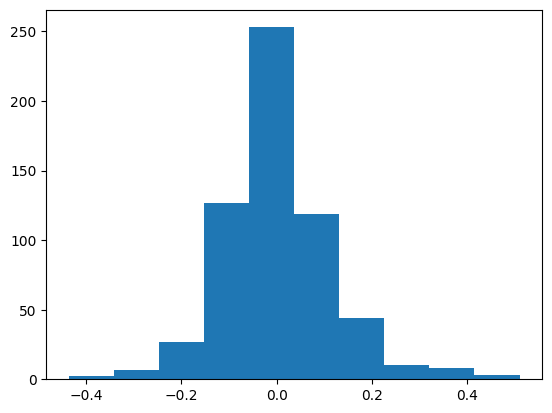

In [24]:
plt.hist(base4['scos']-nsamp['scos'])